### Decision Trees

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

In [2]:
# Column 1: age in years
# Column 2: 1 = male, 0 = female
# Column 3: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
# Column 4: resting blood pressure in mmHg
# Column 5: cholesterol in mg/dl
# Column 6: 1 means > 120 mg/dl, 0 means <= 120 mg/dl
# Column 7: resting electrocardiographic, 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
# Column 8: max heart rate achieved
# Column 9: 1 = yes, 2 = no
# Column 10: ST depression induced by exercise relative to rest
# Column 11: slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping
# Column 12: number of major vessels (0-3) colored by flourosopy
# Column 13: 3 = normal, 6 = fixed defect, 7 = reversable defect
# Column 14: >=1 means heart disease, 0 = no heart disease

myNames = ["age", # column 1
        "sex", # col 2
        "chestPainType", # col 3
        "restingBP", # col 4
        "serumCholesterol", # col 5
        "fastingBloodSugar", # col 6
        "restingEcg", # col 7
        "maxHeartRate", # col 8
        "exerciseInducedAngina", # col 9
        "stDepression", # col 10
        "stSlope", # col 11
        "majorVessels", # col 12
        "thalassemia", # col 13
        "diagnosis"] # col 14
assert len(myNames) == 14

data=pd.read_csv("data/processed.cleveland.data", sep=',', names=myNames, na_values=["?", '?'])
data = data.dropna() # Drop rows with missing data
data.iloc[:, -1] = data.iloc[:, -1].clip(0, 1) # clip last column (output) between 0 and 1, both inclusive

# Convert all columns to float
for name in myNames:
    data[name] = pd.to_numeric(data[name],errors = 'coerce')

m = data.shape[0] # num examples
n = data.shape[1] - 1 # num features

print("Num features:", n)
print("Num examples:", m)
    
# a few examples from the dataset 
print()
print(data.head())

X = data.values[:, :-1]
y = data.values[:, -1:]



categoricalColumnsNames = ["sex", 
                      "chestPainType", 
                      "fastingBloodSugar", 
                      "restingEcg", 
                      "exerciseInducedAngina", 
                      "stSlope",
                      "majorVessels",
                      "thalassemia"]
continuousColumns = data.drop(categoricalColumnsNames, axis=1)
continuousColumnsNames = [name for name in myNames if name not in categoricalColumnsNames and name != "diagnosis"]
categoricalColumns = data.drop(continuousColumnsNames, axis=1)
if "diagnosis" in continuousColumns:
    continuousColumns = continuousColumns.drop("diagnosis", axis=1)
if "diagnosis" not in categoricalColumns:
    categoricalColumns = data["diagnosis"]

# Feature selection
data = data.drop("fastingBloodSugar", axis=1)
myNames.remove("fastingBloodSugar")
data = data.drop("restingEcg", axis=1)
myNames.remove("restingEcg")
data = data.drop("serumCholesterol", axis=1)
myNames.remove("serumCholesterol")


Num features: 13
Num examples: 297

    age  sex  chestPainType  restingBP  serumCholesterol  fastingBloodSugar  \
0  63.0  1.0            1.0      145.0             233.0                1.0   
1  67.0  1.0            4.0      160.0             286.0                0.0   
2  67.0  1.0            4.0      120.0             229.0                0.0   
3  37.0  1.0            3.0      130.0             250.0                0.0   
4  41.0  0.0            2.0      130.0             204.0                0.0   

   restingEcg  maxHeartRate  exerciseInducedAngina  stDepression  stSlope  \
0         2.0         150.0                    0.0           2.3      3.0   
1         2.0         108.0                    1.0           1.5      2.0   
2         2.0         129.0                    1.0           2.6      2.0   
3         0.0         187.0                    0.0           3.5      3.0   
4         2.0         172.0                    0.0           1.4      1.0   

   majorVessels  thalassem

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Normalization
# Binary features do not need normalization as they are already 0 or 1

numeric_features = ['age', 'restingBP', "serumCholesterol", "maxHeartRate", "stDepression", "majorVessels"]

for f in numeric_features:
    if f not in myNames:
        numeric_features.remove(f)


# Nominal categorical features have no hierarchical order (as opposed to [very healthy, healthy, unhealthy, very unhealthy])
nominal_categorical_features = ["chestPainType", "restingEcg", "thalassemia"]

for f in nominal_categorical_features:
    if f not in myNames:
        nominal_categorical_features.remove(f)

data_normalized = data.copy()

scaler = StandardScaler() # or MinMaxScaler()
data_normalized[numeric_features] = scaler.fit_transform(data_normalized[numeric_features])

encoder = OneHotEncoder()
nominal_cat_encoded = encoder.fit_transform(data_normalized[nominal_categorical_features])
nominal_cat_encoded = pd.DataFrame(nominal_cat_encoded.toarray(), columns=encoder.get_feature_names_out(nominal_categorical_features))

data_normalized = pd.concat([data_normalized.drop(nominal_categorical_features, axis=1), nominal_cat_encoded], axis=1)
data_normalized = data_normalized.dropna(subset=['diagnosis']) # Drop NaN diagnosis 
data_normalized = data_normalized.dropna()
print("Num features after encoding + normalization:", data_normalized.shape[1])

X_train, X_test, y_train, y_test = train_test_split(data_normalized.drop("diagnosis", axis=1), 
                                                data_normalized["diagnosis"], 
                                                test_size=0.25, 
                                                random_state=42)

Num features after encoding + normalization: 16


Best hyperparameters:  {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross Validation Score:  0.7532769556025369
Training Accuracy: 0.8310502283105022
Test Accuracy: 0.7808219178082192
Cross-validation scores: [0.71666667 0.9        0.79661017 0.76271186 0.79661017]
Mean CV score: 0.7945197740112995
Confusion Matrix:
                Predicted No    Predicted Yes
Actual No         31              10
Actual Yes        6               26

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.76      0.79        41
         1.0       0.72      0.81      0.76        32

    accuracy                           0.78        73
   macro avg       0.78      0.78      0.78        73
weighted avg       0.79      0.78      0.78        73



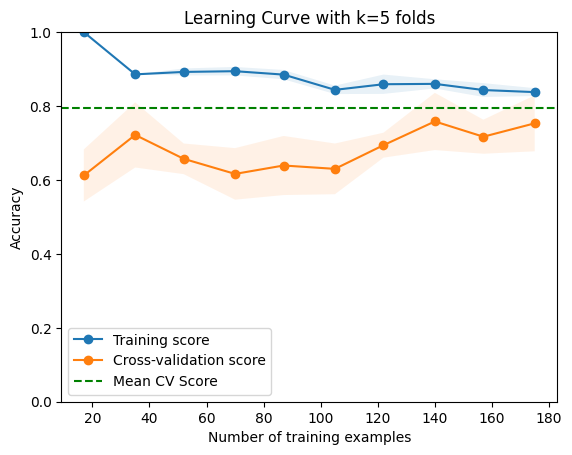

In [4]:
from sklearn.metrics import classification_report

# Create a Decision Tree classifier object
dt_classifier = DecisionTreeClassifier(random_state=60)

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)

grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

# Print the accuracy of the best model
print("Best Cross Validation Score: ", grid_search.best_score_)

# Get the best hyperparameters
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']

# Train the decision tree with the best hyperparameters
dt_classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict training set labels
y_pred_train = dt_classifier.predict(X_train)

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print training accuracy
print("Training Accuracy:", train_accuracy)

# Evaluate the model on the test data
y_pred_test = dt_classifier.predict(X_test)

# Calculate the accuracy of the model on the test data
test_accuracy = accuracy_score(y_test, y_pred_test)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

# Use k-fold cross-validation to estimate the accuracy of the model
cv_scores = cross_val_score(dt_classifier, X, y.ravel(), cv=5)
mean_cv_score = cv_scores.mean()

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", mean_cv_score)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

# Print confusion matrix with labels
print("Confusion Matrix:")
print("                Predicted No    Predicted Yes")
print("Actual No        ", tn, "            ", fp)
print("Actual Yes       ", fn, "             ", tp)

# Generate classification report
cr = classification_report(y_test, y_pred_test)

# Print classification report
print("\nClassification Report:")
print(cr)

from sklearn.model_selection import learning_curve

# Define the training sizes for the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=dt_classifier,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate means and standard deviations for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean,  'o-', label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.axhline(y=np.mean(cv_scores), color='g', linestyle='--', label='Mean CV Score')  # Add line for mean CV score
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve with k=5 folds")
plt.legend()
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.show()
